In [1]:
import numpy as np
import pandas as pd

import data_manipulation_v2 as dm
import time
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

%matplotlib inline

ModuleNotFoundError: No module named 'xgboost'

In [145]:
#Import datasets
txn_og = dm.transactions_merged()
train = dm.train_v2()
test = pd.read_csv('../new_sample_submission_v2.csv')
memb = dm.members_v2()
#ul_var = pd.read_csv('../final_user_log.csv')

In [144]:
snapshot_date = '2017-02-28'

In [6]:
memb.head()

,city,bd,gender,registered_via,registration_init_time,new_id
0,1,0,NaN,7,2011-09-14,15008
1,6,32,female,9,2011-09-15,576289
2,13,63,male,9,2011-09-18,336808
3,1,0,NaN,7,2011-09-18,450516
4,4,28,female,9,2011-09-20,104907


In [11]:
#Prep - sort transactions
txn_og = txn_og.sort_values(['new_id', 'transaction_date', 'membership_expire_date'])
#Prep - limit transactions to end of Jan
txn=txn_og[txn_og['transaction_date']<=snapshot_date]

In [15]:
#Some members in test group don't have any transactions. All members in train group have transactions.
#88k members in test gorup also in train group.
test['in_txn']=test['new_id'].isin(txn_og['new_id'])
train['in_txn']=train['new_id'].isin(txn_og['new_id'])
test['in_train']=test['new_id'].isin(train['new_id'])
print(test['in_txn'].value_counts())
print(train['in_txn'].value_counts())
print(test['in_train'].value_counts())

True    907471
Name: in_txn, dtype: int64
True    970960
Name: in_txn, dtype: int64
True     801490
False    105981
Name: in_train, dtype: int64


In [5]:
#Check datasets
print(train.shape)
print(test.shape)
print(txn_og.shape)
print(ul_var.shape)
print(train['new_id'].nunique())
print(txn_og['new_id'].nunique())
print(test['new_id'].nunique())

(992931, 3)
(970960, 4)
(16411725, 9)
(992931, 8)
992931
1079663
970960


In [92]:
txn_og['in_train']=txn_og['new_id'].isin(train['new_id'])
txn['in_train']=txn['new_id'].isin(train['new_id'])
txn_og['in_test']=txn_og['new_id'].isin(test['new_id'])
txn['in_test']=txn['new_id'].isin(test['new_id'])

C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [93]:
#Seems like 31,497 users only have transactions in Feb
#2,097 users that are in train only have transactions in Feb
#30,616 users that are in test only have transactions in Feb
print((txn_og[(txn_og['in_train']==True)]['new_id'].nunique()) - (txn[txn['in_train']==True]['new_id'].nunique()))
print((txn_og[(txn_og['in_test']==True)]['new_id'].nunique()) - (txn[txn['in_test']==True]['new_id'].nunique()))

2524
27794


In [94]:
print(max(txn[txn['in_train']==True]['membership_expire_date']))

2023-08-17 00:00:00


## Investigating Transactions

*Looking into transactions where the membership_expiry_date < transaction_date*

In [ ]:
#Adding some features
#txn['in_train']=txn['new_id'].isin(train['new_id'])
#txn['odd_transactions']=txn['membership_expire_date']<txn['transaction_date']
#txn['1970']=txn['membership_expire_date']=='1970-01-01'
#txn['in_train'].value_counts()

In [ ]:
pd.crosstab(index=txn['odd_transactions'], columns=txn['in_train'], normalize='index')

In [ ]:
#Odd transactions are more likely to be auto renew transactions
pd.crosstab(index=txn['odd_transactions'], columns=txn['is_auto_renew'], normalize='index')

In [ ]:
#Odd transactions are more likely to be cancelled transactions
pd.crosstab(index=txn['odd_transactions'], columns=txn['is_cancel'], normalize='index')

In [ ]:
#397 of the odd transactions are caused by '1970'
pd.crosstab(index=txn['odd_transactions'], columns=txn['1970'], normalize='index')
pd.crosstab(index=txn['odd_transactions'], columns=txn['1970'])

In [ ]:
#226 bad transactions are in the training set
pd.crosstab(index=txn['in_train'], columns=txn['1970'])

In [ ]:
#0.4% of transactions have membership_expire_date<transaction_date
memb_exp_test=txn[txn['membership_expire_date']<txn['transaction_date']]
print(memb_exp_test.shape[0])
print(txn.shape[0])
print(memb_exp_test.shape[0]/txn.shape[0])
print(txn['new_id'].nunique())
print(memb_exp_test['new_id'].nunique())

In [ ]:
#Almost all records with membership_expire_date<transaction_date are auto_renew memberships
print(memb_exp_test[memb_exp_test['is_auto_renew']==1]['is_auto_renew'].sum())
print(txn[txn['is_auto_renew']==1].shape)

In [ ]:
#Most of the records with membership_expire_date<transaction_date are cancelled memberships - are these late payments?
#ALL of these are also auto-renew memberships
print(memb_exp_test[memb_exp_test['is_cancel']==1]['is_cancel'].sum())
memb_exp_test[(memb_exp_test['is_cancel']==1)&(memb_exp_test['is_auto_renew']==1)].shape

In [ ]:
#The rest of the auto_renew memberships
memb_exp_test[(memb_exp_test['is_cancel']==0)&(memb_exp_test['is_auto_renew']==1)].shape

In [ ]:
#Looks like the rest of the records have lots of instances of membership_expire_date = '1970-01-01'
memb_exp_test[memb_exp_test['is_auto_renew']==0].head(10)
#15 records where membership_expire_date is not is not 1970-01-01 and is not auto_renew
odd_ones_out=memb_exp_test[(memb_exp_test['membership_expire_date']!='1970-01-01') & (memb_exp_test['is_auto_renew']==0)]
#Seems like all of these have plan_list_price of 0
odd_ones_out.head(15)

In [ ]:
#is_cancel=txn[txn['is_cancel']==1]
#print(is_cancel.shape)
#is_cancel['diff_dates']=is_cancel['membership_expire_date']-is_cancel['transaction_date']
#is_cancel['diff_dates']=is_cancel['diff_dates']/ np.timedelta64(1, 'D')
#sns.distplot(is_cancel[is_cancel['diff_dates']>0]['diff_dates'])

In [ ]:
#Determine if member had an odd transaction
txn['odd_txn_flag'] = txn['new_id'].isin(memb_exp_test['new_id'])

## Feature Engineering
 
<font color='red'>*Note that for the test group, we'll have access to less transactions - using transactions up to March 31st 2017 to predict memberships that expire in April 2017. Therefore, we should train using data up to the end of Feb to predict churn for memberships that expire in the month of March 2017.*</font>

Each transaction feature is stored in a pandas dataframe:

- **txn_cnts (all members)**: Count number of transactions per member; note that this dataframe is no longer included since the transaction count is in the txn_lp_high dataframe
- **tot_plan_pmt (all members)**: Sum of payment plan days, plan list price, and actual amount paid. Also - average price per day, and difference between plan list price and actual amount paid
- **txn_lp_high (all members)**: Count of, and percentage of transactions that have higher list price than actual amount paid
- **txn_prev_churn (churned members)**: Count number of times members churned, i.e. transaction date - membership expire date from previous transaction is greater than 30 days
- **txn_ar_stop (all members)**: % of transactions that are auto renew and whether a member has stopped auto-renewing in the duration of their membership
- **txn_pmt_change (payment change members)**: Count number of times member changed payment type 
- **txn_cancelled (all members)**: % of transactions that are cancelled and whether a members has cancelled their membership in the duration of their membership
- **txn_cancelled_last (all members)**: If the member has a cancelled transaction as their last transaction
- **free_trial (all members)**: If the member has a free trial as their last transaction, and percentage of transactions that are free trials, and percentage of total payment_plan_days that are free trials
- **memb_expire (all members)**: Compares the maximum membership expiry date and the membership expiry date of the most recent transaction; also determines if the member's most recent membership expiry date is greater than Feb 2017 (March 2017 for test set), but March 2017 and April 2017 for new data. Also include member tenure

All dfs are to be merged into one df, for transaction attributes per member

Next:
- Transactions matrix

### Number of Transactions

In [16]:
#Number of transactions
txn_cnts = txn.groupby(['new_id']).size().reset_index(name='txn_cnt')

### Total Payment Plan Days, Plan List Price, Actual Amount Paid

In [17]:
#Sum of payment_plan_days
tot_plan_pmt = txn.groupby(['new_id'])[['payment_plan_days', 'plan_list_price', 'actual_amount_paid']].sum().reset_index()
tot_plan_pmt['avg_daily_paid'] = tot_plan_pmt['actual_amount_paid'] / tot_plan_pmt['payment_plan_days']
tot_plan_pmt['list_actual_diff'] = tot_plan_pmt['plan_list_price'] - tot_plan_pmt['actual_amount_paid']
tot_plan_pmt.head()

,new_id,payment_plan_days,plan_list_price,actual_amount_paid,avg_daily_paid,list_actual_diff
0,0,120,396,396,3.300000,0
1,1,573,2831,2980,5.200698,65387
2,2,750,3725,3874,5.165333,65387
3,3,360,1788,1788,4.966667,0
4,4,573,2831,2980,5.200698,65387


### Number, and Percentage of Transactions where Plan List Price Higher than Actual Amount Paid

In [19]:
#Note that plan_list_price is never lower than actual_amount_paid
txn['list_actual_diff'] = txn['plan_list_price'] - txn['actual_amount_paid']
txn_lp_high = txn[txn['list_actual_diff'] > 0].groupby('new_id')['list_actual_diff'].count().reset_index(name='lp_high_cnt')
txn_lp_high = txn_cnts.merge(txn_lp_high, on = 'new_id', how = 'left')
txn_lp_high['per_lp_high'] = txn_lp_high['lp_high_cnt']/txn_lp_high['txn_cnt']
txn_lp_high.drop('lp_high_cnt', axis = 1, inplace = True)
txn_lp_high.head()

C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,new_id,txn_cnt,per_lp_high
0,0,4,NaN
1,1,20,0.050000
2,2,26,0.038462
3,3,12,NaN
4,4,20,0.050000


### Number of Times Churned

In [20]:
#Previous churn: determine if transaction date-membership expiry date from previous row is >30days 
txn['shifted_expiry'] = txn.groupby('new_id')['membership_expire_date'].shift()
txn['memb_gap'] = (txn['transaction_date'] - txn['shifted_expiry'])
txn['prev_churn'] = (txn['memb_gap']/np.timedelta64(1, 'D'))>30
txn.head()

C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,new_id,list_actual_diff,shifted_expiry,memb_gap,prev_churn
890749,41,30,99,99,1,2016-11-16,2016-12-15,0,0,0,NaT,NaT,False
890751,41,30,99,99,1,2016-12-15,2017-01-15,0,0,0,2016-12-15,0 days,False
890748,41,30,99,99,1,2017-01-15,2017-02-15,0,0,0,2017-01-15,0 days,False
890750,41,30,99,99,1,2017-02-15,2017-03-15,0,0,0,2017-02-15,0 days,False
15907290,39,31,149,149,1,2015-01-31,2015-03-19,0,1,0,NaT,NaT,False


In [21]:
#Aggregate number of times churned
txn_prev_churn = txn[txn['prev_churn'] == True].groupby('new_id')['prev_churn'].count().reset_index(name='prev_churn_cnt')
txn_prev_churn = txn_prev_churn.merge(txn_cnts, on='new_id', how='inner')
txn_prev_churn['prev_churn_per'] = txn_prev_churn['prev_churn_cnt'] / txn_prev_churn['txn_cnt']
txn_prev_churn.drop(['prev_churn_cnt', 'txn_cnt'], axis = 1, inplace = True)
txn_prev_churn.head()

,new_id,prev_churn_per
0,1,0.050000
1,4,0.050000
2,5,0.045455
3,8,0.333333
4,9,0.142857


### Stopped Auto Renew

In [22]:
#Value of 'is_auto_renew' for last transaction
txn_ar_last = txn.groupby(['new_id'])['is_auto_renew'].last().reset_index(name='last_ar')
txn_ar_last['last_ar'].value_counts()

1    893016
0    154051
Name: last_ar, dtype: int64

In [23]:
#Changed auto renew:
txn_ar_change = txn.groupby(['new_id'])['is_auto_renew'].mean().reset_index(name='mean_ar')
txn_ar_stop = txn_ar_change.merge(txn_ar_last, on='new_id', how='inner')
txn_ar_stop['stopped_ar']=(txn_ar_stop['mean_ar'] < 1) & (txn_ar_stop['mean_ar'] > 0) & (txn_ar_stop['last_ar'] == 0)
txn_ar_stop[txn_ar_stop['stopped_ar']==True].head()

,new_id,mean_ar,last_ar,stopped_ar
9,9,0.571429,0,True
54,56,0.937500,0,True
78,81,0.857143,0,True
232,238,0.666667,0,True
238,244,0.875000,0,True


In [24]:
txn_ar_stop.drop('last_ar', axis = 1, inplace = True)
txn_ar_stop['stopped_ar'].value_counts()

False    1029146
True       17921
Name: stopped_ar, dtype: int64

### Changed Payment Method

In [25]:
#Changed payment method:determine if transaction date-membership expiry date from previous row is >30days 
txn['shifted_pmt'] = txn.groupby('new_id')['payment_method_id'].shift()
txn['pmt_change'] = (txn['payment_method_id'] != txn['shifted_pmt']) & (txn['shifted_pmt'].isnull() != True)
txn['pmt_change'].value_counts()

C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Cathy\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


False    15826596
True       260823
Name: pmt_change, dtype: int64

In [26]:
#Aggregate number of times changed payment method
txn_pmt_change = txn[txn['pmt_change'] == True].groupby('new_id')['pmt_change'].count().reset_index(name='pmt_change_cnt')
txn_pmt_change.head()

,new_id,pmt_change_cnt
0,7,2
1,8,2
2,9,2
3,21,3
4,23,4


### Cancelled Membership

In [27]:
#Cancelled membership:
txn_cancelled = txn.groupby(['new_id'])['is_cancel'].mean().reset_index(name='mean_cancel')
txn_cancelled.head()

,new_id,mean_cancel
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [28]:
#Cancelled membership in last transaction:
txn_cancelled_last = txn.groupby(['new_id'])['is_cancel'].last().reset_index(name='last_cancel')
txn_cancelled_last['last_cancel'].value_counts()

0    1034884
1      12183
Name: last_cancel, dtype: int64

### Free Trial

In [29]:
#5483 members who have their last transaction as a free trial
free_trial = txn.groupby(['new_id'])['plan_list_price'].last().reset_index(name='last_plan_price')
free_trial['lst_free_trial'] = (free_trial['last_plan_price'] == 0) | (free_trial['last_plan_price'] == 1)
free_trial[free_trial['lst_free_trial']==True].head()

,new_id,last_plan_price,lst_free_trial
54,56,0,True
785,818,0,True
1480,1530,0,True
1538,1591,0,True
2259,2331,0,True


In [30]:
#percentage of total transactions that are free trials
free_trial_cnt = txn[(txn['plan_list_price'] == 0) | (txn['plan_list_price'] == 1)].groupby('new_id')['plan_list_price'].count().reset_index(name='free_trial_cnt')
per_free_trial = txn_cnts.merge(free_trial_cnt, on = 'new_id', how = 'left')
per_free_trial['per_free_trial'] = per_free_trial['free_trial_cnt']/per_free_trial['txn_cnt']
free_trial = free_trial.merge(per_free_trial, on = 'new_id', how = 'inner')

In [31]:
#percentage of total payment_plan_days that are free trial days
free_trial_days = txn[(txn['plan_list_price'] == 0) | (txn['plan_list_price'] == 1)].groupby('new_id')['payment_plan_days'].sum().reset_index(name='free_trial_days')
per_days_free_trial = tot_plan_pmt[['payment_plan_days', 'new_id']].merge(free_trial_days, on = 'new_id', how = 'left')
per_days_free_trial['per_days_free_trial'] = per_days_free_trial['free_trial_days']/per_days_free_trial['payment_plan_days']
free_trial = free_trial.merge(per_days_free_trial, on = 'new_id', how = 'inner')

In [32]:
free_trial.drop(['last_plan_price', 'txn_cnt', 'free_trial_cnt', 'payment_plan_days', 'free_trial_days'], axis = 1, inplace = True)
free_trial.head()

,new_id,lst_free_trial,per_free_trial,per_days_free_trial
0,0,False,NaN,NaN
1,1,False,0.050000,0.0
2,2,False,0.038462,0.0
3,3,False,NaN,NaN
4,4,False,0.050000,0.0


### Max Membership Expire Date
Note that we assume lst_memb_expire as the "current membership" expiry date. Therefore lst_memb_expire>Feb 2017 then the member is probably not churning

In [119]:
#max_memb_expire and lst_memb_expire
max_memb_expire = txn.groupby(['new_id'])['membership_expire_date'].max().reset_index(name='max_memb_expire')
lst_memb_expire = txn.groupby(['new_id'])['membership_expire_date'].last().reset_index(name='lst_memb_expire')
fst_txn_dt = txn.groupby(['new_id'])['transaction_date'].first().reset_index(name='fst_transaction_date')
memb_expire = max_memb_expire.merge(lst_memb_expire, on = 'new_id', how = 'inner')
memb_expire = memb_expire.merge(fst_txn_dt, on = 'new_id', how = 'left')

In [120]:
memb_expire['not_equal'] = memb_expire['max_memb_expire'] != memb_expire['lst_memb_expire']
#Some weird shit happening when max_memb_expire does not equal lst_memb_expire
#txn_memb_expire = txn.merge(memb_expire, on = 'new_id', how = 'left')
#txn_memb_expire[(txn_memb_expire['not_equal']==True) & (txn_memb_expire['new_id']==217)].head(100)

In [121]:
memb_expire['lst_memb_expire_post'] = memb_expire['lst_memb_expire'] >= '2017-04-01'

In [122]:
memb_expire = memb_expire.merge(memb[['new_id', 'registration_init_time']], on = 'new_id', how = 'left')
memb_expire['registration_init_time'] = memb_expire['registration_init_time'].fillna(memb_expire['fst_transaction_date'])
memb_expire['memb_tenure_days'] = (pd.to_datetime('2017-02-28') - memb_expire['registration_init_time'])/np.timedelta64(1, 'D')
memb_expire['lst_memb_expire_days'] = (memb_expire['lst_memb_expire'] - pd.to_datetime('2017-03-31'))/np.timedelta64(1, 'D')

In [123]:
memb_expire.head()

,new_id,max_memb_expire,lst_memb_expire,fst_transaction_date,not_equal,lst_memb_expire_post,registration_init_time,memb_tenure_days,lst_memb_expire_days
0,0,2017-03-15,2017-03-15,2016-11-16,False,False,2014-06-08,996.0,-16.0
1,1,2017-04-19,2017-04-19,2015-01-31,False,True,2015-01-31,759.0,19.0
2,2,2017-03-26,2017-03-26,2015-01-26,False,False,2014-09-27,885.0,-5.0
3,3,2017-03-15,2017-03-15,2016-03-15,False,False,2016-03-15,350.0,-16.0
4,4,2017-04-23,2017-04-23,2015-01-31,False,True,2015-01-31,759.0,23.0


In [124]:
np.max(memb_expire['lst_memb_expire'])

Timestamp('2022-12-12 00:00:00')

In [125]:
#126,062 members have membership expiry dates after Feb
memb_expire.drop(['max_memb_expire', 'registration_init_time', 'lst_memb_expire', 'fst_transaction_date'], inplace = True, axis = 1)
memb_expire.head()

,new_id,not_equal,lst_memb_expire_post,memb_tenure_days,lst_memb_expire_days
0,0,False,False,996.0,-16.0
1,1,False,True,759.0,19.0
2,2,False,False,885.0,-5.0
3,3,False,False,350.0,-16.0
4,4,False,True,759.0,23.0


## Merging Feature Dataframes

In [126]:
import functools

txn_features = [
    train, tot_plan_pmt, txn_ar_stop, txn_cancelled, 
    txn_cancelled_last, free_trial, txn_lp_high, 
    txn_prev_churn, txn_pmt_change, memb_expire]
f_txn = functools.reduce(lambda left,right: pd.merge(left,right,on='new_id', how='left'), txn_features)

f_txn.drop('in_txn', axis = 1, inplace = True)

print(f_txn.shape)

(970960, 22)


In [127]:
#2524 nulls
f_txn[(pd.isnull(f_txn['payment_plan_days']) == True)]['new_id'].nunique()

2524

In [128]:
f_txn.columns

Index(['is_churn', 'new_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'avg_daily_paid', 'list_actual_diff', 'mean_ar',
       'stopped_ar', 'mean_cancel', 'last_cancel', 'lst_free_trial',
       'per_free_trial', 'per_days_free_trial', 'txn_cnt', 'per_lp_high',
       'prev_churn_per', 'pmt_change_cnt', 'not_equal', 'lst_memb_expire_post',
       'memb_tenure_days', 'lst_memb_expire_days'],
      dtype='object')

In [129]:
f_txn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 22 columns):
is_churn                970960 non-null int8
new_id                  970960 non-null uint32
payment_plan_days       968436 non-null float64
plan_list_price         968436 non-null float64
actual_amount_paid      968436 non-null float64
avg_daily_paid          968436 non-null float64
list_actual_diff        968436 non-null float64
mean_ar                 968436 non-null float64
stopped_ar              968436 non-null object
mean_cancel             968436 non-null float64
last_cancel             968436 non-null float64
lst_free_trial          968436 non-null object
per_free_trial          330042 non-null float64
per_days_free_trial     330040 non-null float64
txn_cnt                 968436 non-null float64
per_lp_high             341272 non-null float64
prev_churn_per          261822 non-null float64
pmt_change_cnt          136352 non-null float64
not_equal               968436 

In [130]:
str_col = ['per_free_trial', 'per_days_free_trial', 'txn_cnt'
           , 'per_lp_high', 'prev_churn_per', 'pmt_change_cnt', 'lst_memb_expire_days', 'memb_tenure_days']
f_txn[str_col] = f_txn[str_col].fillna(0)

In [131]:
str_col = ['stopped_ar', 'last_cancel', 'lst_free_trial', 'not_equal', 'lst_memb_expire_post']
f_txn[str_col] = f_txn[str_col].fillna(False)

In [132]:
str_col = ['payment_plan_days', 'plan_list_price', 'actual_amount_paid']
f_txn[str_col] = f_txn[str_col].fillna(f_txn[str_col].mode().iloc[0])

In [133]:
str_col = ['mean_ar', 'mean_cancel']
f_txn[str_col] = f_txn[str_col].fillna(f_txn[str_col].mean().iloc[0])

In [134]:
f_txn['avg_daily_paid'] = f_txn['actual_amount_paid']/f_txn['payment_plan_days']
f_txn['list_actual_diff'] = f_txn['plan_list_price'] - f_txn['actual_amount_paid']

In [135]:
f_txn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 22 columns):
is_churn                970960 non-null int8
new_id                  970960 non-null uint32
payment_plan_days       970960 non-null float64
plan_list_price         970960 non-null float64
actual_amount_paid      970960 non-null float64
avg_daily_paid          970960 non-null float64
list_actual_diff        970960 non-null float64
mean_ar                 970960 non-null float64
stopped_ar              970960 non-null bool
mean_cancel             970960 non-null float64
last_cancel             970960 non-null float64
lst_free_trial          970960 non-null bool
per_free_trial          970960 non-null float64
per_days_free_trial     970960 non-null float64
txn_cnt                 970960 non-null float64
per_lp_high             970960 non-null float64
prev_churn_per          970960 non-null float64
pmt_change_cnt          970960 non-null float64
not_equal               970960 non-

In [143]:
#f_txn.drop('is_churn', axis = 1, inplace = True)
f_txn.to_csv('../final_txn_v2.csv', index=False)

## Casual Exploratory Analysis

Oh so casual *_hairflick_

In [ ]:
#4% of transactions have a plan_list_price of zero
txn[txn['plan_list_price']==0]['plan_list_price'].count()/txn['plan_list_price'].count()

In [ ]:
#Looking at prices of membership transactions: 99 & 149 & 129 corresponds to monthly membership
plt.figure(num=None, figsize=(16, 4), dpi=80)
sns.countplot(txn['plan_list_price'])

In [ ]:
print(txn[(txn['plan_list_price']==129)|(txn['plan_list_price']==99)|(txn['plan_list_price']==149)]['payment_plan_days'].value_counts())

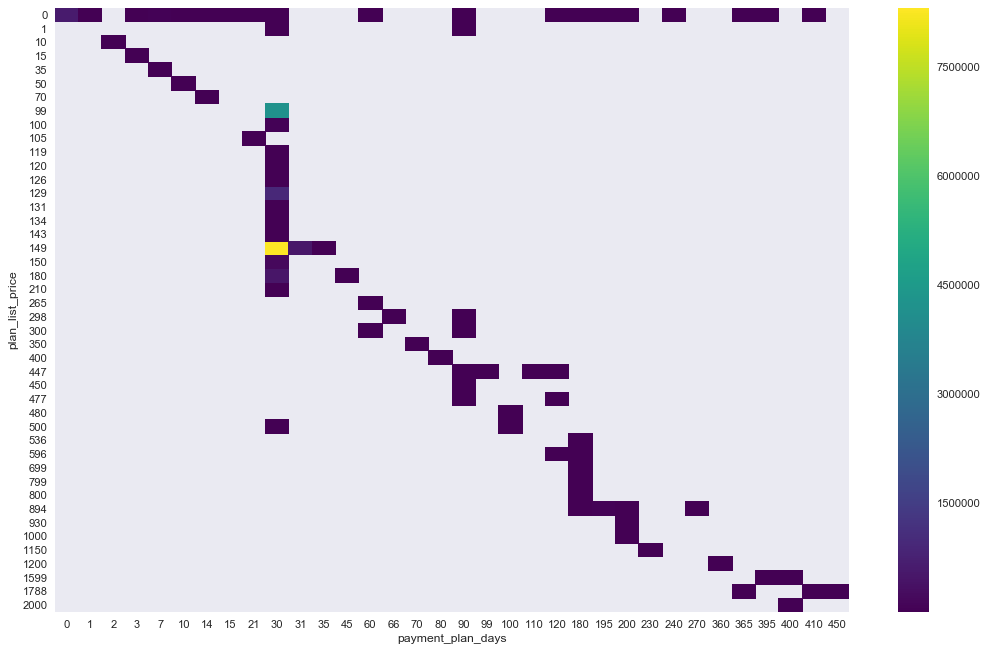

In [96]:
txn_test = txn.groupby(['plan_list_price', 'payment_plan_days'])['plan_list_price'].count().reset_index(name='cnt_txn')
txn_test = txn_test.pivot(index='plan_list_price', columns='payment_plan_days', values='cnt_txn')
plt.figure(num=None, figsize=(16, 10), dpi=80)
sns.heatmap(txn_test, cmap='viridis')

## Are Features Useful?

### Total Payment Plan Days

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'payment_plan_days', data=f_txn)

### Difference Between Listed and Paid Price

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'list_actual_diff', data=f_txn)

### Number of Transactions where Plan List Price is Higher than Actual Amount Paid

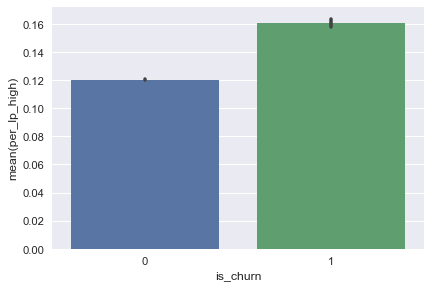

In [82]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'per_lp_high', data=f_txn)

### Percentage of Transactions where Plan List Price is Higher than Actual Amount Paid

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'per_lp_high', data=f_txn)

### Previous Churn

In [ ]:
plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('prev_churn_cnt', 'is_churn', data=f_txn)

### % of Transactions as Auto Renew

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'mean_ar', data=f_txn)

### Stopped Auto Renew

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'stopped_ar', data=f_txn)

### Changed Payment Methods

In [ ]:
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('pmt_change_cnt', 'is_churn', data=f_txn)

### % of Transactions Cancelled

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'mean_cancel', data=f_txn)

### Last Transaction is Cancelled Transaction

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'last_cancel', data=f_txn)

### Last Transaction is Free Trial

In [ ]:
plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
sns.barplot('is_churn', 'lst_free_trial', data=f_txn)

In [ ]:
f_txn.corr()